# Working with multiple samples (and coordinate systems)

In this notebook, we will work with mouse liver spatial transcriptomics data generated using [Resolve Biosciences’ Molecular Cartography technology](https://www.resolvebiosciences.com/), to illustrate the use of multiple samples and coordinate systems in [Harpy](https://github.com/saeyslab/harpy) and [SpatialData](https://github.com/scverse/spatialdata).

## 1. Read the images into a SpatialData object backed by a zarr store.

In [26]:
import os

import tempfile
import uuid

from spatialdata import SpatialData

import harpy as hp

sdata = SpatialData()

default_tmp_path = tempfile.gettempdir()

zarr_path = os.path.join(default_tmp_path, f"sdata_{uuid.uuid4()}.zarr")

sdata.write(zarr_path)

Add image layers.

In [27]:
from dask_image import imread
from spatialdata.transformations import Identity, Scale

from harpy.datasets.registry import get_registry

registry = get_registry()
arr_a1_1 = imread.imread(registry.fetch("transcriptomics/resolve/mouse/20272_slide1_A1-1_DAPI.tiff"))
arr_a1_2 = imread.imread(registry.fetch("transcriptomics/resolve/mouse/20272_slide1_A1-2_DAPI.tiff"))

pixel_size = 0.138  # pixel size in micron for resolve
scale = Scale(axes=["x", "y"], scale=[pixel_size, pixel_size])

sdata = hp.im.add_image_layer(
    sdata,
    arr=arr_a1_1,
    output_layer="image_a1_1",
    transformations={"a1_1_pixel": Identity(), "a1_1_micron": scale},
    c_coords="DAPI",
    scale_factors=[2, 2, 2, 2],
    overwrite=True,
)

sdata = hp.im.add_image_layer(
    sdata,
    arr=arr_a1_2,
    output_layer="image_a1_2",
    transformations={"a1_2_pixel": Identity(), "a1_2_micron": scale},
    c_coords="DAPI",
    scale_factors=[2, 2, 2, 2],
    overwrite=True,
)

2025-11-19 10:07:14,354 - harpy.image._manager - INFO - Writing results to layer 'image_a1_1'
2025-11-19 10:07:17,896 - harpy.image._manager - INFO - Writing results to layer 'image_a1_2'


## 2. Specify coordinate system when plotting.

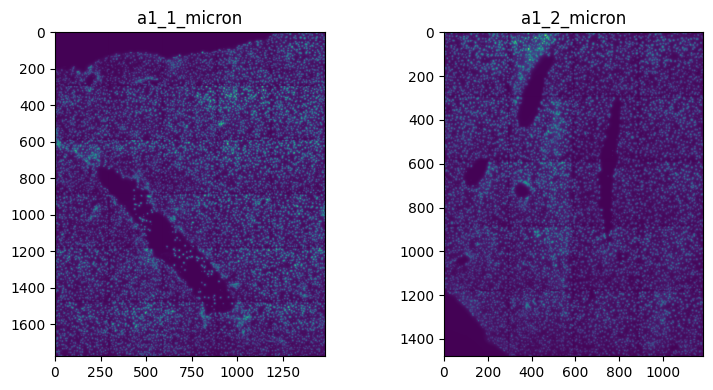

In [28]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

channel = "DAPI"
render_images_kwargs = {
    "cmap": "viridis",
}

img_layer = ["image_a1_1", "image_a1_2"]
to_coordinate_system = ["a1_1_micron", "a1_2_micron"]

for _img_layer, _to_coordinate_system, _ax in zip(img_layer, to_coordinate_system, axes, strict=True):
    show_kwargs = {"title": _to_coordinate_system, "colorbar": False}
    _ax = hp.pl.plot_sdata(
        sdata,
        img_layer=_img_layer,
        channel=channel,
        crd=None,
        to_coordinate_system=_to_coordinate_system,
        render_images_kwargs=render_images_kwargs,
        show_kwargs=show_kwargs,
        ax=_ax,
    )

plt.tight_layout()
plt.show()

Visualize a crop:

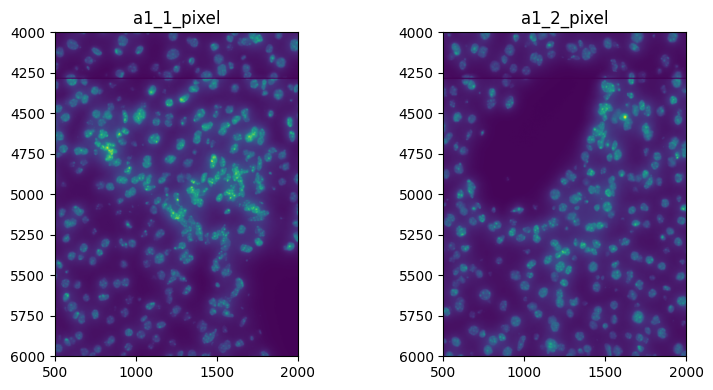

In [29]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

channel = "DAPI"
render_images_kwargs = {
    "cmap": "viridis",
}

img_layer = ["image_a1_1", "image_a1_2"]
to_coordinate_system = ["a1_1_pixel", "a1_2_pixel"]

for _img_layer, _to_coordinate_system, _ax in zip(img_layer, to_coordinate_system, axes, strict=True):
    show_kwargs = {"title": _to_coordinate_system, "colorbar": False}
    _ax = hp.pl.plot_sdata(
        sdata,
        img_layer=_img_layer,
        channel=channel,
        crd=[500, 2000, 4000, 6000],
        to_coordinate_system=_to_coordinate_system,
        render_images_kwargs=render_images_kwargs,
        show_kwargs=show_kwargs,
        ax=_ax,
    )

plt.tight_layout()
plt.show()

Or in micron

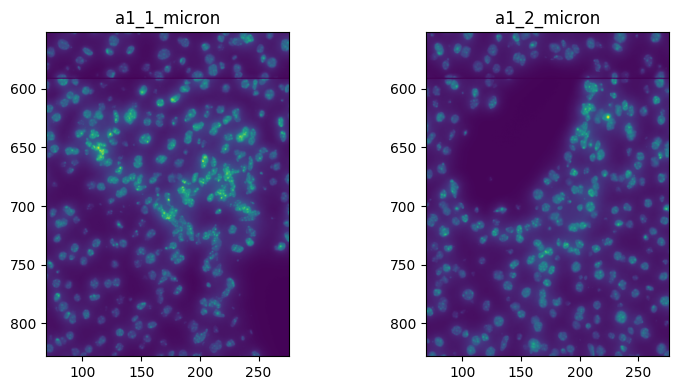

In [30]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

channel = "DAPI"
render_images_kwargs = {
    "cmap": "viridis",
}

img_layer = ["image_a1_1", "image_a1_2"]
to_coordinate_system = ["a1_1_micron", "a1_2_micron"]

for _img_layer, _to_coordinate_system, _ax in zip(img_layer, to_coordinate_system, axes, strict=True):
    show_kwargs = {"title": _to_coordinate_system, "colorbar": False}
    _ax = hp.pl.plot_sdata(
        sdata,
        img_layer=_img_layer,
        channel=channel,
        crd=[69, 276, 552, 828],
        to_coordinate_system=_to_coordinate_system,
        render_images_kwargs=render_images_kwargs,
        show_kwargs=show_kwargs,
        ax=_ax,
    )

plt.tight_layout()
plt.show()

## 3. Image processing.

Do some image processing on the full image, no need to specify a coordinate system

In [31]:
sdata = hp.im.min_max_filtering(
    sdata, img_layer="image_a1_1", output_layer="image_a1_1_min_max", size_min_max_filter=40, overwrite=True
)

2025-11-19 10:07:20,747 - harpy.image._map - INFO - 'combine_z' is False, but not all 'z-slices' spefified in 'fn_kwargs'/'func' ({'size_min_max_filter': 40}/<function min_max_filtering.<locals>._apply_min_max_filter at 0x5608b32e0>). Specifying z-slices ([0]).
2025-11-19 10:07:20,747 - harpy.image._map - INFO - 'combine_c' is False, but not all channels spefified in 'fn_kwargs'/'func' ({np.int64(0): {'size_min_max_filter': 40}}/{np.int64(0): <function min_max_filtering.<locals>._apply_min_max_filter at 0x5608b32e0>}). Specifying channels (['DAPI']).
2025-11-19 10:07:20,749 - harpy.image._filters - WARNING - Provided value for min max filter size is even ('40'). To prevent unexpected output, we set min max filter to '41'.
2025-11-19 10:07:20,764 - harpy.image._manager - INFO - Writing results to layer 'image_a1_1_min_max'


When doing some image processing on a crop, you need to specify the coordinate system to which the crop is defined

In [32]:
for img_layer, to_coordinate_system in zip(["image_a1_1", "image_a1_2"], ["a1_1_pixel", "a1_2_pixel"], strict=True):
    sdata = hp.im.min_max_filtering(
        sdata,
        img_layer=img_layer,
        output_layer=f"{img_layer}_min_max",
        size_min_max_filter=40,
        crd=[500, 2000, 4000, 6000],
        to_coordinate_system=to_coordinate_system,
        overwrite=True,
    )

2025-11-19 10:07:27,429 - harpy.image._map - INFO - 'combine_z' is False, but not all 'z-slices' spefified in 'fn_kwargs'/'func' ({'size_min_max_filter': 40}/<function min_max_filtering.<locals>._apply_min_max_filter at 0x558b37100>). Specifying z-slices ([0]).
2025-11-19 10:07:27,429 - harpy.image._map - INFO - 'combine_c' is False, but not all channels spefified in 'fn_kwargs'/'func' ({np.int64(0): {'size_min_max_filter': 40}}/{np.int64(0): <function min_max_filtering.<locals>._apply_min_max_filter at 0x558b37100>}). Specifying channels (['DAPI']).
2025-11-19 10:07:27,431 - harpy.image._filters - WARNING - Provided value for min max filter size is even ('40'). To prevent unexpected output, we set min max filter to '41'.
2025-11-19 10:07:27,444 - harpy.image._manager - INFO - Writing results to layer 'image_a1_1_min_max'
2025-11-19 10:07:28,043 - harpy.utils._io - WARNING - layer with name 'image_a1_1_min_max' already exists. Overwriting...
2025-11-19 10:07:28,178 - harpy.image._map -

INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   


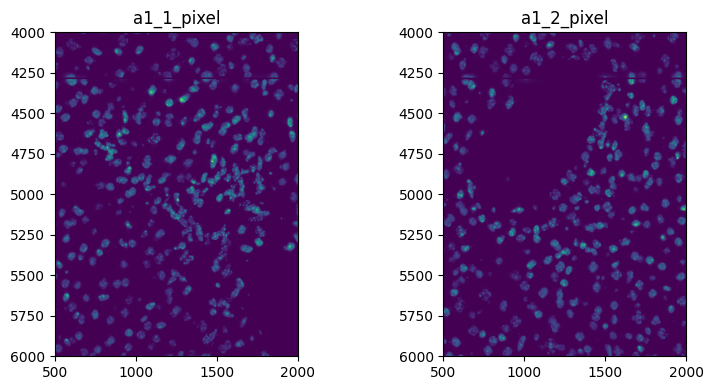

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

channel = "DAPI"
render_images_kwargs = {
    "cmap": "viridis",
}

for img_layer, to_coordinate_system, ax in zip(
    ["image_a1_1_min_max", "image_a1_2_min_max"], ["a1_1_pixel", "a1_2_pixel"], axes, strict=True
):
    show_kwargs = {"title": to_coordinate_system, "colorbar": False}
    ax = hp.pl.plot_sdata(
        sdata,
        img_layer=img_layer,
        channel=channel,
        crd=None,
        to_coordinate_system=to_coordinate_system,
        render_images_kwargs=render_images_kwargs,
        show_kwargs=show_kwargs,
        ax=ax,
    )

plt.tight_layout()
plt.show()

## 4. Segmentation.

In [34]:
# no need to specify coordinate system if no crop is specifed
import torch
from dask.distributed import LocalCluster, Client

cluster = LocalCluster(
    n_workers=1
    if torch.backends.mps.is_available() or torch.cuda.is_available()
    else 8,  # If mps/cuda device available, it is better to increase chunk size to maximal value that fits on the gpu, and set n_workers to 1.
    threads_per_worker=1,
    memory_limit="32GB",
    # local_directory=os.environ.get( "TMPDIR" ),
)

client = Client(cluster)

print(client.dashboard_link)

sdata = hp.im.segment(
    sdata,
    img_layer="image_a1_1_min_max",
    output_labels_layer="labels_a1_1",
    output_shapes_layer="shapes_a1_1",
    overwrite=True,
    crd=None,
)

# but need to specify coordinate system when crop is defined

sdata = hp.im.segment(
    sdata,
    img_layer="image_a1_2_min_max",
    output_labels_layer="labels_a1_2",
    output_shapes_layer="shapes_a1_2",
    overwrite=True,
    crd=[600, 2000, 4000, 6000],
    to_coordinate_system="a1_2_pixel",
)
client.close()

/Users/arnedf/VIB/harpy/.venv_harpy/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54603 instead
  warnings.warn(


http://127.0.0.1:54603/status


/Users/arnedf/VIB/harpy/.venv_harpy/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
pretrained model /Users/arnedf/.cellpose/models/cpsam not found, using default model
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
Resizing is deprecated in v4.0.1+
2025-11-19 10:07:45,606 - harpy.image.segmentation._segmentation - INFO - Linking labels across chunks.
2025-11-19 10:07:45,614 - harpy.image._manager - INFO - Writing results to layer 'labels_a1_1'
no parent found for <ome_zarr.reader.Label object at 0x5602e8cb0>: None
2025-11-19 10:07:45,856 - harpy.shape._manager - INFO - Finished vectorizing. Dissolving shapes at

INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   


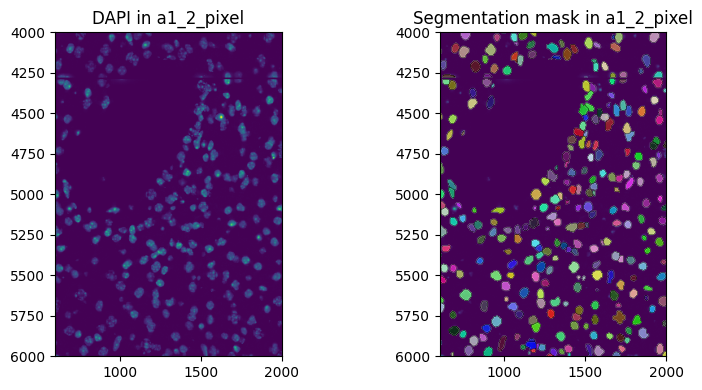

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

channel = "DAPI"
img_layer = "image_a1_2_min_max"
labels_layer = "labels_a1_2"
crd = [600, 2000, 4000, 6000]  # Crop in pixels. One could also choose to do the crop in micron coordinates
to_coordinate_system = "a1_2_pixel"

render_images_kwargs = {"cmap": "viridis"}
render_labels_kwargs = {"fill_alpha": 0.6, "outline_alpha": 0.4}
show_kwargs = {"title": f"DAPI in {to_coordinate_system}", "colorbar": False}

_ax = hp.pl.plot_sdata(
    sdata,
    img_layer=img_layer,
    crd=crd,
    to_coordinate_system=to_coordinate_system,
    channel=channel,
    render_images_kwargs=render_images_kwargs,
    show_kwargs=show_kwargs,
    ax=axes[0],
)
# _ax.axis("off")

show_kwargs = {"title": f"Segmentation mask in {to_coordinate_system}", "colorbar": False}
_ax = hp.pl.plot_sdata(
    sdata,
    img_layer=img_layer,
    labels_layer=labels_layer,
    crd=crd,
    to_coordinate_system=to_coordinate_system,
    channel=channel,
    render_images_kwargs=render_images_kwargs,
    render_labels_kwargs=render_labels_kwargs,
    show_kwargs=show_kwargs,
    ax=axes[1],
)
# _ax.axis("off")

plt.tight_layout()
plt.show()

Read the transcripts downloaded previously. For downstream analysis it is convenient if the transcripts are stored in pixels (intrinsic coordinate system of the images), and registered with the images. Therefore, if transcripts are delivered in micron, it is possible to specify an affine transformation via the parameter `transform_matrix` of the function `harpy.io.read_transcripts` that converts from micron to pixels, and registers the transcripts with the images. A micron coordinate system will be added to the resulting points layer of the `SpatialData` object if `to_micron_coordinate_system` is specified. We refer to the docstring of `harpy.io.read_transcripts` for more information.

Transcripts from Resolve Biosciences’ Molecular Cartography technology are already in pixels. By specifying the pixel size and the micron coordinate system, the function `harpy.io.read_transcripts` takes care of adding a micron coordinate system.

In [36]:
path_transcripts_a1_1 = registry.fetch("transcriptomics/resolve/mouse/20272_slide1_A1-1_results.txt")
path_transcripts_a1_2 = registry.fetch("transcriptomics/resolve/mouse/20272_slide1_A1-2_results.txt")

sdata = hp.io.read_transcripts(
    sdata,
    path_count_matrix=path_transcripts_a1_1,
    column_x=0,
    column_y=1,
    column_gene=3,
    delimiter="\t",
    header=None,
    output_layer="transcripts_a1_1",
    to_coordinate_system="a1_1_pixel",
    to_micron_coordinate_system="a1_1_micron",
    pixel_size=pixel_size,  # size of pixels in micron
    transform_matrix=None,  # transcripts are already in pixels, and registered with the images
    overwrite=True,
)

sdata = hp.io.read_transcripts(
    sdata,
    path_count_matrix=path_transcripts_a1_2,
    column_x=0,
    column_y=1,
    column_gene=3,
    delimiter="\t",
    header=None,
    output_layer="transcripts_a1_2",
    to_coordinate_system="a1_2_pixel",
    to_micron_coordinate_system="a1_2_micron",
    pixel_size=pixel_size,  # size of pixels in micron
    transform_matrix=None,  # transcripts are already in pixels, and registered with the images
    overwrite=True,
)

2025-11-19 10:07:59,536 - harpy.io._transcripts - INFO - No transform matrix given, will use identity matrix.
2025-11-19 10:07:59,537 - harpy.io._transcripts - INFO - Transform matrix used:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
2025-11-19 10:07:59,537 - harpy.io._transcripts - INFO - Adding micron coordinate system for transcripts: 'a1_1_micron'.
2025-11-19 10:08:03,341 - harpy.io._transcripts - INFO - No transform matrix given, will use identity matrix.
2025-11-19 10:08:03,341 - harpy.io._transcripts - INFO - Transform matrix used:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
2025-11-19 10:08:03,342 - harpy.io._transcripts - INFO - Adding micron coordinate system for transcripts: 'a1_2_micron'.


Verify that transformation associated to points layer in the pixel coordinate system is indeed the identity, and verify that the labels have same transformation associated to them.

In [37]:
from spatialdata.transformations import get_transformation

print(
    f"points:\n {get_transformation(sdata['transcripts_a1_2'], to_coordinate_system='a1_2_pixel')}\n",
)
print(
    f"image:\n{get_transformation(sdata['image_a1_2_min_max'], to_coordinate_system='a1_2_pixel')}\n",
)  # one crop was taken, so an extra translation is defined on image.
print(
    f"image:\n{get_transformation(sdata['labels_a1_2'], to_coordinate_system='a1_2_pixel')}\n",
)  # two times a crop was taken, so a sequence of two translations is defined on labels and the associated shapes.
print(
    f"shapes:\n{get_transformation(sdata['shapes_a1_2'], to_coordinate_system='a1_2_pixel')}\n",
)  # two times a crop was taken, so a sequence of two translations is defined on labels and the associated shapes.

points:
 Identity 

image:
Sequence 
    Translation (c, y, x)
        [   0. 4000.  500.]
    Identity 

image:
Sequence 
    Translation (y, x)
        [  0. 100.]
    Sequence 
        Translation (y, x)
            [4000.  500.]
        Identity 

shapes:
Sequence 
    Translation (x, y)
        [100.   0.]
    Sequence 
        Translation (x, y)
            [ 500. 4000.]
        Identity 



2025-11-19 10:08:06,367 - harpy.plot._plot_sdata - INFO - Column 'gene' of 'sdata.points[transcripts_a1_1]' is of dtype categorical, while 'genes' is 'None'. We proceed with converting to dtype object, to prevent spatialdata-plot to plot all genes as categories. In case of a backed SpatialData object, this will not affect the underlying zarr store, only the in-memory representation of 'sdata.points[transcripts_a1_1][gene]'.


INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Rasterizing image for faster rendering.                                                                   


/Users/arnedf/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                


2025-11-19 10:08:15,056 - harpy.plot._plot_sdata - INFO - Column 'gene' of 'sdata.points[transcripts_a1_2]' is of dtype categorical, while 'genes' is 'None'. We proceed with converting to dtype object, to prevent spatialdata-plot to plot all genes as categories. In case of a backed SpatialData object, this will not affect the underlying zarr store, only the in-memory representation of 'sdata.points[transcripts_a1_2][gene]'.


INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Rasterizing image for faster rendering.                                                                   


/Users/arnedf/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                


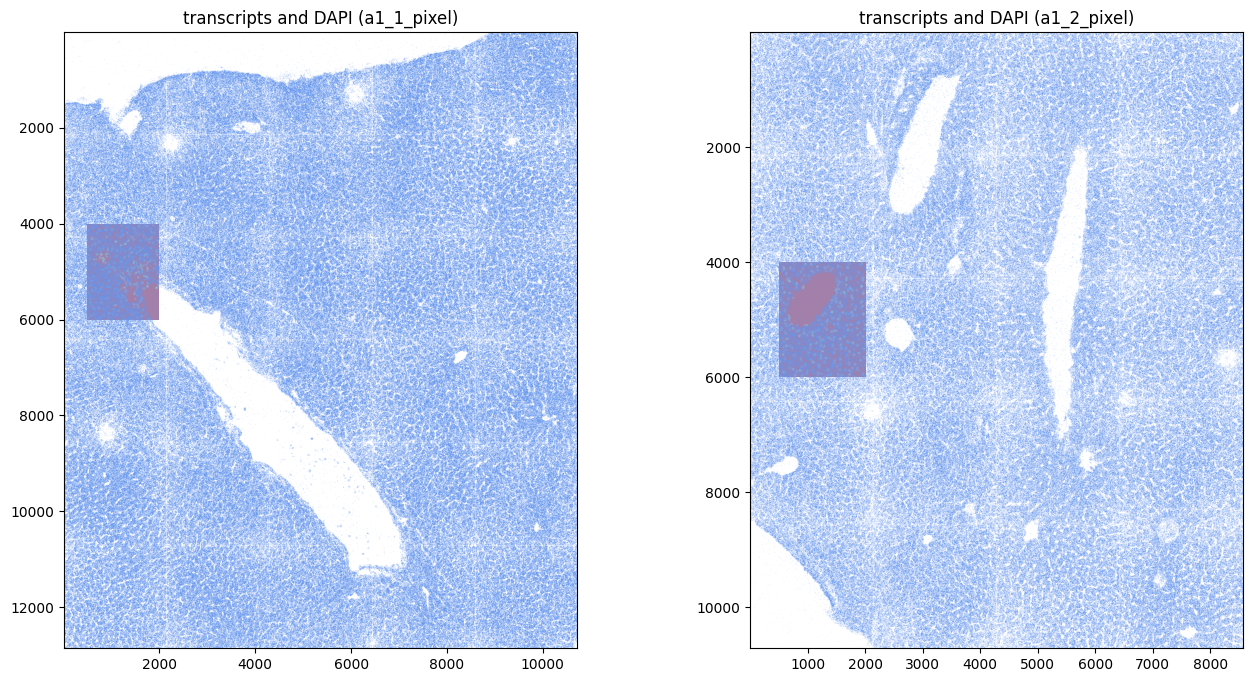

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

render_images_kwargs = {
    "cmap": "viridis",
    "alpha": 0.5,
}

img_layer = ["image_a1_1_min_max", "image_a1_2_min_max"]
points_layer = ["transcripts_a1_1", "transcripts_a1_2"]
to_coordinate_system = ["a1_1_pixel", "a1_2_pixel"]

for _img_layer, _points_layer, _to_coordinate_system, _ax in zip(
    img_layer, points_layer, to_coordinate_system, axes, strict=True
):
    show_kwargs = {
        "title": f"transcripts and DAPI ({_to_coordinate_system})",
        "colorbar": False,
    }

    hp.pl.plot_sdata_genes(
        sdata,
        points_layer=_points_layer,
        img_layer=_img_layer,
        genes=None,  # plot all genes
        color="cornflowerblue",
        size=0.1,
        frac=0.5,  # only plot half of them
        to_coordinate_system=_to_coordinate_system,
        show_kwargs=show_kwargs,
        render_images_kwargs=render_images_kwargs,
        ax=_ax,
    )

Or visualize a crop:

INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Rasterizing image for faster rendering.                                                                   
INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                


/Users/arnedf/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Rasterizing image for faster rendering.                                                                   
INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                


/Users/arnedf/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


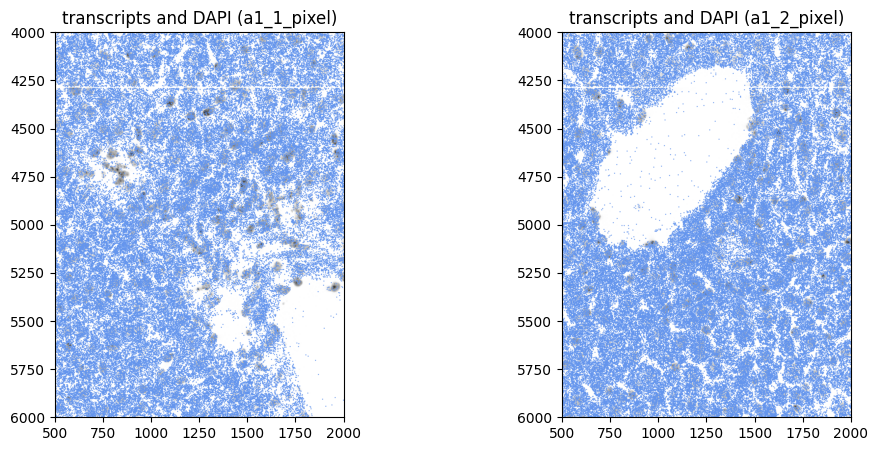

In [39]:
# we query the points layers outside of spatialdata, because querying points via spatialdata.bounding_box_query is slow

crd = [500, 2000, 4000, 6000]

points_layer = ["transcripts_a1_1", "transcripts_a1_2"]

to_coordinate_system = ["a1_1_pixel", "a1_2_pixel"]

for _points_layer, _to_coordinate_system in zip(points_layer, to_coordinate_system, strict=True):
    to_coordinate_system = _to_coordinate_system  # we query in 'intrinsic' pixel coordinate system

    y_start = crd[2]
    x_start = crd[0]

    y_end = crd[3]
    x_end = crd[1]

    name_x = "x"
    name_y = "y"

    y_query = f"{y_start} <={name_y} < {y_end}"
    x_query = f"{x_start} <={name_x} < {x_end}"

    query = f"{y_query} and {x_query}"

    sdata[f"{_points_layer}_queried"] = sdata[_points_layer].query(query)


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

render_images_kwargs = {
    "cmap": "binary",
}

img_layer = ["image_a1_1_min_max", "image_a1_2_min_max"]
points_layer = [f"{_points_layer}_queried" for _points_layer in points_layer]
to_coordinate_system = ["a1_1_pixel", "a1_2_pixel"]

for _img_layer, _points_layer, _to_coordinate_system, _ax in zip(
    img_layer, points_layer, to_coordinate_system, axes, strict=True
):
    show_kwargs = {
        "title": f"transcripts and DAPI ({_to_coordinate_system})",
        "colorbar": False,
    }

    hp.pl.plot_sdata_genes(
        sdata,
        points_layer=_points_layer,
        img_layer=_img_layer,
        genes=None,  # plot all genes
        color="cornflowerblue",
        size=1,
        frac=None,  # only plot half of them
        to_coordinate_system=_to_coordinate_system,
        show_kwargs=show_kwargs,
        render_images_kwargs=render_images_kwargs,
        ax=_ax,
    )

    del sdata[_points_layer]

## 5. Create the AnnData table.

In [40]:
# Use dask cluster for optimal processing. For this dummy example, one could also work without a dask cluster.
cluster = LocalCluster(
    n_workers=8,
    threads_per_worker=1,
    processes=True,
    memory_limit="8GB",
    # local_directory=os.environ.get( "TMPDIR" ),
)

client = Client(cluster)

print(client.dashboard_link)

sdata = hp.tb.allocate(
    sdata,
    labels_layer="labels_a1_1",
    points_layer="transcripts_a1_1",
    to_coordinate_system="a1_1_pixel",  # allocation step should always be run in pixel coordinates
    output_layer="table",
    update_shapes_layers=False,
    append=False,
    overwrite=True,
)

# append gene count of labels_a1_2 and points_a1_2 to anndata object with name 'table'
sdata = hp.tb.allocate(
    sdata,
    labels_layer="labels_a1_2",
    points_layer="transcripts_a1_2",
    to_coordinate_system="a1_2_pixel",
    output_layer="table",
    update_shapes_layers=False,
    append=True,
    overwrite=True,
)

client.close()

/Users/arnedf/VIB/harpy/.venv_harpy/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54626 instead
  warnings.warn(
2025-11-19 10:08:30,474 - harpy.image._image - INFO - There seems to be more than one coordinate system defined on the provided spatial element ('['a1_1_pixel', 'a1_1_micron']'). We only consider the coordinate sytem specified via parameter 'to_coordinate_system': 'a1_1_pixel'.
2025-11-19 10:08:30,486 - harpy.table._allocation - INFO - Calculating cell counts.


http://127.0.0.1:54626/status


/Users/arnedf/VIB/harpy/.venv_harpy/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/arnedf/VIB/harpy/.venv_harpy/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/Users/arnedf/VIB/harpy/.venv_harpy/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configurat

In [41]:
from spatialdata.models import TableModel

print(sdata["table"].uns[TableModel.ATTRS_KEY], "\n")  # -> the table is annotated by "labels_a1_1" and "labels_a1_2"
print(
    sdata["table"].uns[TableModel.ATTRS_KEY][TableModel.REGION_KEY_KEY], "\n"
)  # -> column in .obs that holds the spatial element that is annotating the instance
print(
    sdata["table"].uns[TableModel.ATTRS_KEY][TableModel.INSTANCE_KEY]
)  # -> column in .obs that holds the instance id in the corresponding spatial element

{'region': ['labels_a1_1', 'labels_a1_2'], 'region_key': 'fov_labels', 'instance_key': 'cell_ID'} 

fov_labels 

cell_ID


In [42]:
display(sdata["table"].obs.head())
display(sdata["table"].obs.tail())

cell_ID   fov_labels
cells                                        
18_labels_a1_1_0eab1c65       18  labels_a1_1
19_labels_a1_1_0eab1c65       19  labels_a1_1
20_labels_a1_1_0eab1c65       20  labels_a1_1
21_labels_a1_1_0eab1c65       21  labels_a1_1
22_labels_a1_1_0eab1c65       22  labels_a1_1

cell_ID   fov_labels
cells                                         
346_labels_a1_2_4db60fce      346  labels_a1_2
348_labels_a1_2_4db60fce      348  labels_a1_2
349_labels_a1_2_4db60fce      349  labels_a1_2
352_labels_a1_2_4db60fce      352  labels_a1_2
353_labels_a1_2_4db60fce      353  labels_a1_2

## 6. Leiden clustering.

In [43]:
sdata = hp.tb.preprocess_transcriptomics(
    sdata,
    labels_layer=["labels_a1_1", "labels_a1_2"],
    table_layer="table",
    output_layer="table_preprocessed",
    update_shapes_layers=False,
    overwrite=True,
)  # we can also choose to set output_layer equal to 'table'.

2025-11-19 10:08:41,408 - harpy.table._preprocess - INFO - Calculating cell size from provided labels_layer 'labels_a1_1'
2025-11-19 10:08:41,513 - harpy.table._preprocess - INFO - Calculating cell size from provided labels_layer 'labels_a1_2'
/Users/arnedf/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
2025-11-19 10:08:41,601 - harpy.table._preprocess - INFO - Saving non preprocessed data matrix to '.layers[raw_counts]'.
/Users/arnedf/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/Users/arnedf/VIB/harpy/.venv_harpy/lib/python3.12/site-packages/spatialdata/models/models.py:1183: UserWarning: Converting `region_key: fov_labels` to categorical dtype.
  convert_region_column_to_categor

In [44]:
hp.tb.leiden(
    sdata,
    labels_layer=["labels_a1_1", "labels_a1_2"],
    table_layer="table_preprocessed",
    output_layer="table_preprocessed",
    overwrite=True,
)

2025-11-19 10:08:45,568 - harpy.utils._io - WARNING - layer with name 'table_preprocessed' already exists. Overwriting...


SpatialData object, with associated Zarr store: /private/var/folders/q5/7yhs0l6d0x771g7qdbhvkvmr0000gp/T/sdata_306204f5-165d-417a-850a-6e35f89efe6f.zarr
├── Images
│     ├── 'image_a1_1': DataTree[cyx] (1, 12864, 10720), (1, 6432, 5360), (1, 3216, 2680), (1, 1608, 1340), (1, 804, 670)
│     ├── 'image_a1_1_min_max': DataArray[cyx] (1, 2000, 1500)
│     ├── 'image_a1_2': DataTree[cyx] (1, 10720, 8576), (1, 5360, 4288), (1, 2680, 2144), (1, 1340, 1072), (1, 670, 536)
│     └── 'image_a1_2_min_max': DataArray[cyx] (1, 2000, 1500)
├── Labels
│     ├── 'labels_a1_1': DataArray[yx] (2000, 1500)
│     └── 'labels_a1_2': DataArray[yx] (2000, 1400)
├── Points
│     ├── 'transcripts_a1_1': DataFrame with shape: (<Delayed>, 3) (2D points)
│     └── 'transcripts_a1_2': DataFrame with shape: (<Delayed>, 3) (2D points)
├── Shapes
│     ├── 'shapes_a1_1': GeoDataFrame shape: (341, 1) (2D shapes)
│     └── 'shapes_a1_2': GeoDataFrame shape: (295, 1) (2D shapes)
└── Tables
      ├── 'table': AnnData (6

INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   


/Users/arnedf/VIB/harpy/.venv_harpy/lib/python3.12/site-packages/spatialdata/_core/spatialdata.py:178: UserWarning: The table is annotating 'labels_a1_2', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   


/Users/arnedf/VIB/harpy/.venv_harpy/lib/python3.12/site-packages/spatialdata/_core/spatialdata.py:178: UserWarning: The table is annotating 'labels_a1_1', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   


/Users/arnedf/VIB/harpy/.venv_harpy/lib/python3.12/site-packages/spatialdata/_core/spatialdata.py:178: UserWarning: The table is annotating 'labels_a1_2', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   


/Users/arnedf/VIB/harpy/.venv_harpy/lib/python3.12/site-packages/spatialdata/_core/spatialdata.py:178: UserWarning: The table is annotating 'labels_a1_1', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


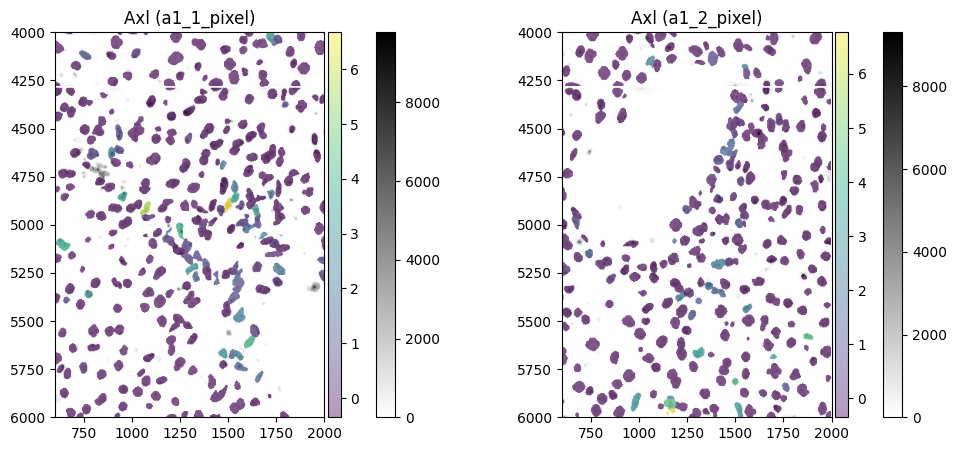

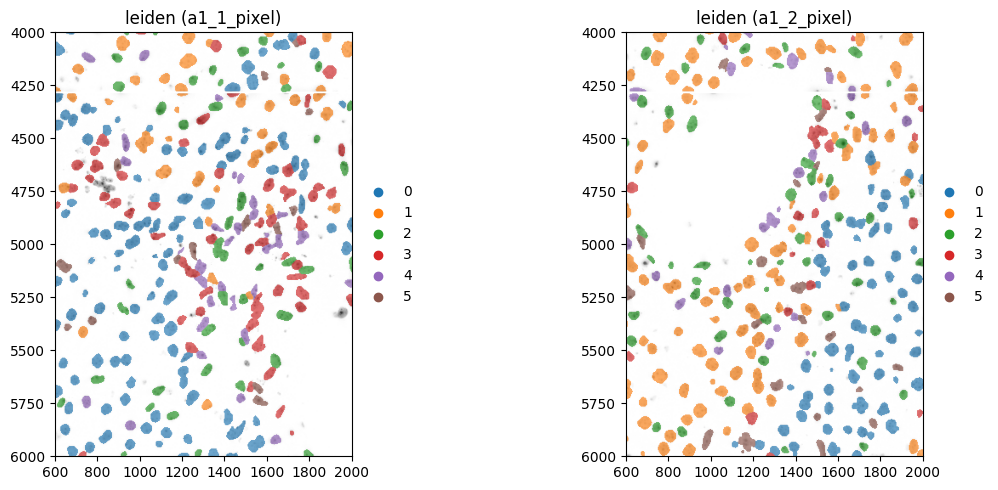

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

channel = "DAPI"
img_layer = ["image_a1_1_min_max", "image_a1_2_min_max"]
labels_layer = ["labels_a1_1", "labels_a1_2"]
to_coordinate_system = ["a1_1_pixel", "a1_2_pixel"]
table_layer = "table_preprocessed"

crd = [600, 2000, 4000, 6000]

render_images_kwargs = {"cmap": "binary"}
render_labels_kwargs = {"fill_alpha": 0.6, "outline_alpha": 0.4}

color = "Axl"

for _img_layer, _labels_layer, _to_coordinate_system, _ax in zip(
    img_layer, labels_layer, to_coordinate_system, axes, strict=True
):
    # subset because querying of points is slow, and we do not need them in this visualization

    sdata_to_plot = sdata.subset(element_names=[_img_layer, _labels_layer, table_layer])

    show_kwargs = {
        "title": f"{color} ({_to_coordinate_system})",
        "colorbar": True,
    }
    _ax = hp.pl.plot_sdata(
        sdata_to_plot,
        img_layer=_img_layer,
        channel=channel,
        crd=crd,
        to_coordinate_system=_to_coordinate_system,
        labels_layer=_labels_layer,
        table_layer=table_layer,
        color=color,
        render_images_kwargs=render_images_kwargs,
        show_kwargs=show_kwargs,
        ax=_ax,
    )

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

color = "leiden"

for _img_layer, _labels_layer, _to_coordinate_system, _ax in zip(
    img_layer, labels_layer, to_coordinate_system, axes, strict=True
):
    sdata_to_plot = sdata.subset(element_names=[_img_layer, _labels_layer, table_layer])

    show_kwargs = {
        "title": f"{color} ({_to_coordinate_system})",
        "colorbar": False,
    }
    _ax = hp.pl.plot_sdata(
        sdata_to_plot,
        img_layer=_img_layer,
        channel=channel,
        crd=crd,
        to_coordinate_system=_to_coordinate_system,
        labels_layer=_labels_layer,
        table_layer=table_layer,
        color=color,
        render_images_kwargs=render_images_kwargs,
        show_kwargs=show_kwargs,
        ax=_ax,
    )

plt.tight_layout()
plt.show()

## 7. Query the labels layers and the associated table layer it annotates.

In [46]:
zarr_path = os.path.join(default_tmp_path, f"sdata_{uuid.uuid4()}.zarr")  # output path for queried sdata

labels_layer = [
    "labels_a1_1",
    "labels_a1_2",
]
crd = [
    (600, 1000, 4000, 5000),
    (700, 1000, 4000, 5000),
]  # queries could also be done in pixels
to_coordinate_system = ["a1_1_pixel", "a1_2_pixel"]

sdata_queried = hp.utils.bounding_box_query(
    sdata,
    labels_layer=labels_layer,
    crd=crd,
    to_coordinate_system=to_coordinate_system,
    copy_img_layer=False,
    copy_shapes_layer=False,
    copy_points_layer=False,
    output=zarr_path,
)

for _labels_layer in labels_layer:
    assert _labels_layer in sdata_queried.labels

2025-11-19 10:08:48,598 - harpy.image._manager - INFO - Writing results to layer 'labels_a1_1'
no parent found for <ome_zarr.reader.Label object at 0x59ab30b30>: None
2025-11-19 10:08:48,655 - harpy.image._manager - INFO - Writing results to layer 'labels_a1_2'
no parent found for <ome_zarr.reader.Label object at 0x562cb1fa0>: None
no parent found for <ome_zarr.reader.Label object at 0x562d6b320>: None
/Users/arnedf/VIB/harpy/.venv_harpy/lib/python3.12/site-packages/spatialdata/_core/spatialdata.py:178: UserWarning: The table is annotating 'labels_a1_1', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/Users/arnedf/VIB/harpy/.venv_harpy/lib/python3.12/site-packages/spatialdata/_core/spatialdata.py:178: UserWarning: The table is annotating 'labels_a1_2', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/Users/arnedf/VIB/harpy/.venv_harpy/lib/python3.12/site-packages/spatialdata/_core/spatialdata.py:178: UserW

In [47]:
from spatialdata.transformations import get_transformation

get_transformation(sdata_queried["labels_a1_1"], to_coordinate_system="a1_1_pixel")

Sequence 
    Translation (y, x)
        [  0. 100.]
    Sequence 
        Translation (y, x)
            [4000.  500.]
        Identity 

In [48]:
sdata_queried["table_preprocessed"]

AnnData object with n_obs × n_vars = 66 × 78
    obs: 'cell_ID', 'fov_labels', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_2_genes', 'pct_counts_in_top_5_genes', 'n_counts', 'shapeSize', 'leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mean', 'std'
    uns: 'umap', 'pca', 'spatialdata_attrs', 'rank_genes_groups', 'log1p', 'leiden', 'neighbors'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'raw_counts'
    obsp: 'connectivities', 'distances'